# Выбор локации для скважины

**Цели и задачи проекта**


Цель: Определить наиболее прибыльный регион для бурения нефтяных скважин с помощью машинного обучения и анализа рисков.


Задачи:
- Загрузить и обработать данные трёх регионов.
- Обучить модель линейной регрессии и оценить её качество.
- Рассчитать минимально необходимый объём нефти для безубыточности и сравнить с прогнозами.
- Определить прибыль по 200 лучшим скважинам.
- Провести анализ рисков методом Bootstrap и выбрать оптимальный регион.


План выполнения проекта
1. Подготовка данных — загрузка, анализ, очистка.
2. Обучение модели — разбиение выборок, обучение и проверка точности.
3. Анализ безубыточности — расчёт необходимого объёма нефти.
4. Оценка прибыли — выбор скважин, расчёт доходов.
5. Анализ рисков — бутстрэп-оценка, доверительный интервал, финальный выбор региона.


## Загрузка и подготовка данных

In [1]:
!pip install --upgrade scikit-learn -q
!pip install matplotlib==3.3.4 -q
!pip install numpy==1.20.1 -q
!pip install scipy==1.8.0 -q
!pip install shap==0.40.0 -q
!pip install imbalanced-learn -q

In [2]:
# Импорт необходимых библиотек
import time
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap

from numpy.random import RandomState
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer 
from sklearn.svm import SVC
from scipy.stats import ttest_ind
from sklearn.ensemble import RandomForestRegressor
from imblearn.over_sampling import SMOTENC
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, LogisticRegression

from sklearn.model_selection import (
    StratifiedKFold,
    RandomizedSearchCV, 
    train_test_split
)

from sklearn.metrics import (
    make_scorer, 
    roc_auc_score, 
    confusion_matrix,
    mean_squared_error
)
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder,
    LabelEncoder,
    MinMaxScaler,
    PolynomialFeatures,
    RobustScaler
)    

In [3]:
RANDOM_STATE = 42
TEST_SIZE = 0.25
state = RandomState(12345)

In [4]:
# Загрузка датасетов
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [5]:
# создание функции для предобработки данных
def preprocess_csv(df_name):
    
    """Проводит предобработку данных в таблице:
        она приводит названия столбцов к нижнему регистру, заменяет пробелы на '_',
        проверяет датасет на наличие дубликатов и удаляет их, выводит количество
        пропусков, проверяет уникальные значения в столбцах, выводит описание числовых столбцов.


        Args:
            df_name: принимает на вход название датафрейма, который необходимо предварительно обработать.

        Returns:
            возвращает основную информацию о таблице, названия столбцов после преобразования, 
            Количество дублированных строк до удаления и после, уникальные значения в категориальных
            и строковых столбцах, описание числовых столбцов и возвращает обработанный датафрейм.

        """ 
    
    # Вывод информации о датафрейме
    print("\n--- Информация о DataFrame ---")
    df_name.info()
    
 # Приведение названий столбцов к нижнему регистру и замена пробелов на "_"
    df_name.columns = [col.lower().replace(" ", "_") for col in df_name.columns]
    print("\n--- Названия столбцов после преобразования ---")
    print(", ".join(df_name.columns))

    # Проверка на наличие дублей
    subset_cols = df_name.columns
    duplicated_count = len(df_name[df_name.duplicated(subset=subset_cols)])
    print(f"\n--- Количество дублированных строк до удаления: {duplicated_count} ---")
    
    # Удаление дублей
    df_name = df_name.drop_duplicates(subset=subset_cols, keep='first').reset_index(drop=True)
    duplicated_count_after = len(df_name[df_name.duplicated(subset=subset_cols)])
    print(f"\n--- Количество дублированных строк после удаления: {duplicated_count_after} ---")
    # Вывод количества пропусков
    print(df_name.isnull().sum())
# Вывод уникальных значений для столбцов с типами 'object' и 'category'
    print("\n--- Уникальные значения в категориальных и строковых столбцах ---")
    for column in df_name.columns:
        if df_name[column].dtype == 'object' or df_name[column].dtype.name == 'category':
            print(f"Столбец '{column}': {df_name[column].unique()}")
# Вывод описания числовых столбцов
    print("\n--- Описание числовых столбцов ---")
    numeric_columns = df_name.select_dtypes(include=['number']).columns
    if numeric_columns.any():
        print(df_name[numeric_columns].describe().round(2))
    else:
        print("Числовые столбцы отсутствуют")

    # Возврат обработанного DataFrame
    return display(df_name.head())

help(preprocess_csv)

Help on function preprocess_csv in module __main__:

preprocess_csv(df_name)
    Проводит предобработку данных в таблице:
    она приводит названия столбцов к нижнему регистру, заменяет пробелы на '_',
    проверяет датасет на наличие дубликатов и удаляет их, выводит количество
    пропусков, проверяет уникальные значения в столбцах, выводит описание числовых столбцов.
    
    
    Args:
        df_name: принимает на вход название датафрейма, который необходимо предварительно обработать.
    
    Returns:
        возвращает основную информацию о таблице, названия столбцов после преобразования, 
        Количество дублированных строк до удаления и после, уникальные значения в категориальных
        и строковых столбцах, описание числовых столбцов и возвращает обработанный датафрейм.



In [6]:
geo_data_0

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
...,...,...,...,...,...
99995,DLsed,0.971957,0.370953,6.075346,110.744026
99996,QKivN,1.392429,-0.382606,1.273912,122.346843
99997,3rnvd,1.029585,0.018787,-1.348308,64.375443
99998,7kl59,0.998163,-0.528582,1.583869,74.040764


In [7]:
preprocess_csv(geo_data_0)


--- Информация о DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

--- Названия столбцов после преобразования ---
id, f0, f1, f2, product

--- Количество дублированных строк до удаления: 0 ---

--- Количество дублированных строк после удаления: 0 ---
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

--- Уникальные значения в категориальных и строковых столбцах ---
Столбец 'id': ['txEyH' '2acmU' '409Wp' ... '3rnvd' '7kl59' '1CWhH']

--- Описание числовых столбцов ---
              f0         f1         f2    product
count  100000.00  100000.00  100000.00  100000.00


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [8]:
preprocess_csv(geo_data_1)


--- Информация о DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

--- Названия столбцов после преобразования ---
id, f0, f1, f2, product

--- Количество дублированных строк до удаления: 0 ---

--- Количество дублированных строк после удаления: 0 ---
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

--- Уникальные значения в категориальных и строковых столбцах ---
Столбец 'id': ['kBEdx' '62mP7' 'vyE1P' ... '09gWa' 'rqwUm' 'relB0']

--- Описание числовых столбцов ---
              f0         f1         f2    product
count  100000.00  100000.00  100000.00  100000.00


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [9]:
preprocess_csv(geo_data_2)


--- Информация о DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

--- Названия столбцов после преобразования ---
id, f0, f1, f2, product

--- Количество дублированных строк до удаления: 0 ---

--- Количество дублированных строк после удаления: 0 ---
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

--- Уникальные значения в категориальных и строковых столбцах ---
Столбец 'id': ['fwXo0' 'WJtFt' 'ovLUW' ... 'tKPY3' 'nmxp2' 'V9kWn']

--- Описание числовых столбцов ---
              f0         f1         f2    product
count  100000.00  100000.00  100000.00  100000.00


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Во всех трех таблицах отсутствуют пропуски, аномалии и дубликаты. Названия столбцов были приведены к нижнему регистру 

Для начала необходимо составить графики распределения наблюдений в каждой таблице, чтобы составить общее представление о данных. чтобы не строить графики отдельно для каждого столбца, создадим функцию, благодаря которой за одну строчку можно создать графики для кажого столбца датафрейма.

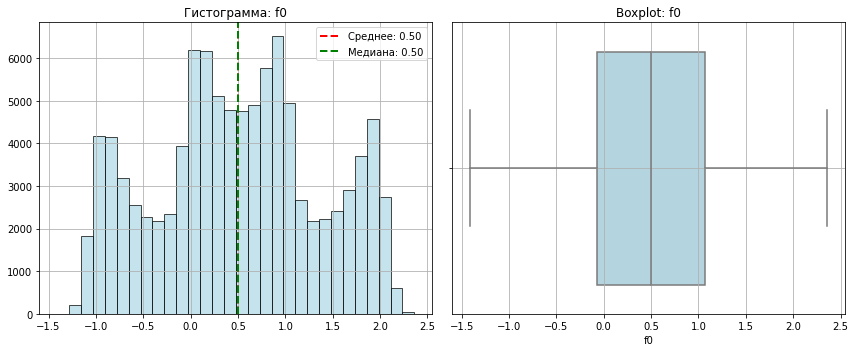

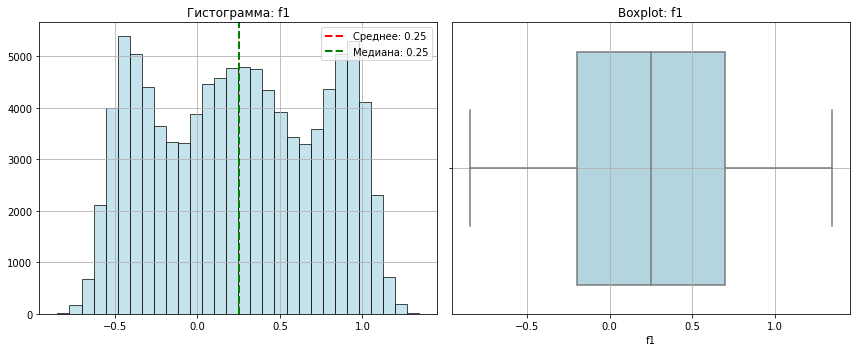

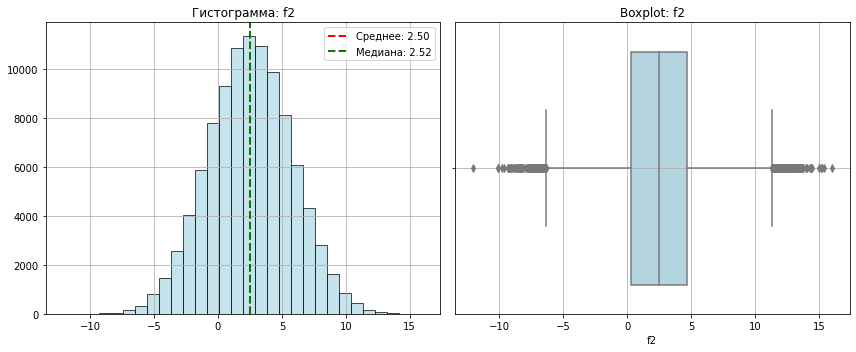

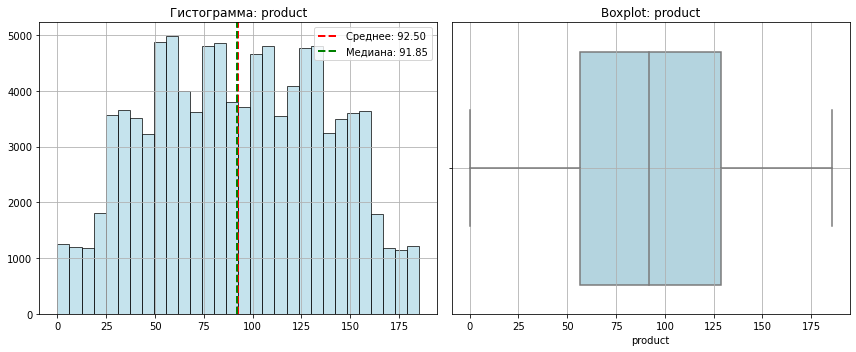

In [10]:
def col_plot(df, cols):
    for col in cols:
        plt.figure(figsize=(12, 5))

        if pd.api.types.is_numeric_dtype(df[col]):
            unique_vals = df[col].nunique()

            mean_val = df[col].mean()
            median_val = df[col].median()

            plt.subplot(1, 2, 1)
            plt.hist(df[col], bins=30, alpha=0.7, color='lightblue', edgecolor='black')
            plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=2, label=f'Среднее: {mean_val:.2f}')
            plt.axvline(median_val, color='green', linestyle='dashed', linewidth=2, label=f'Медиана: {median_val:.2f}')
            plt.legend()
            plt.title(f'Гистограмма: {col}')
            plt.grid(True)

            plt.subplot(1, 2, 2)
            sns.boxplot(x=df[col], color='lightblue', showfliers=True)
            plt.title(f'Boxplot: {col}')
            plt.grid(True)

        else:
            df[col].value_counts().plot(kind='bar', color='grey', edgecolor='black')
            plt.title(f'Распределение категорий: {col}')
            plt.xticks(rotation=45)
            plt.grid(True)

        plt.tight_layout()
        plt.show()

# построим графики для первой таблицы
col_plot(geo_data_0, geo_data_0.columns[1:])        

Распределение признаков f0, f1 и product  выглядит симметричным. Значения распределены внутри межквартильного диапазона, без явных выбросов, что указывает на нормальное распределение без экстремальных значений.

Что касается признака f2, по гистограмме видно, что его распределение ассиметрично и явно смещено в большую сторону. Среднее значение 2.50, а медиана — 2.52, что указывает на небольшой уклон в сторону положительных значений. боксплот показывает наличие выбросов, что может указывать на необычные или ошибочные данные в этом признаке. Большинство значений сосредоточено внутри межквартильного диапазона.

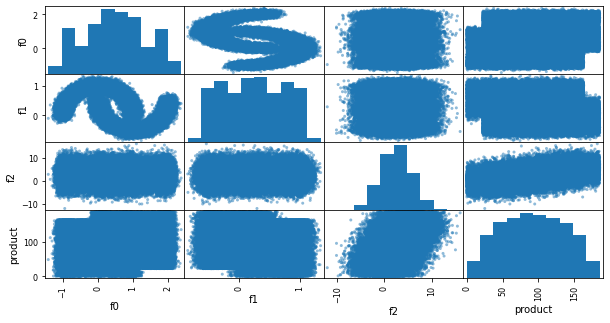

In [11]:
pd.plotting.scatter_matrix(geo_data_0, figsize=(10, 5))
plt.show()

Признаки f0 и f1 имеют нелинейную (криволинейную) зависимость (две пересекающиеся параболы). Это может быть сложная взаимосвязь, которую следует учитывать для улучшения работы модели.


У признаков f0 и f1 с признаком Product обнаружена нелинейная зависимость. 


Product и f2 - линейная положительная зависимость. Следовательно, этот признак имеет влияние на объём запасов нефти.

<AxesSubplot:>

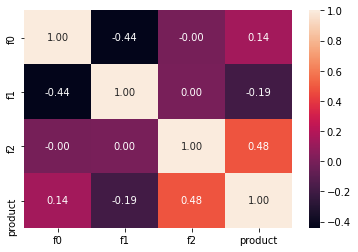

In [12]:
# построим матрицу корреляции
sns.heatmap(geo_data_0.corr(), annot=True, fmt='.2f') 

Признаки f0 и f1 образуют отрицательную корреляцию, а значит с увеличением одного признака, значение другого снижается. Признаки f1 и f2 совсем друг на друга не влияют. Коэффициент корреляции равный 0.48 между признаками f2 и product подтверждает зависимость данных признаков друг от друга. Однако мультиколлинеарность отсутствует 

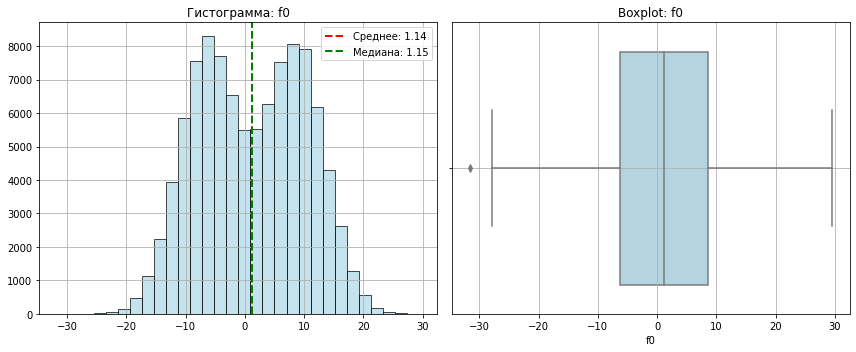

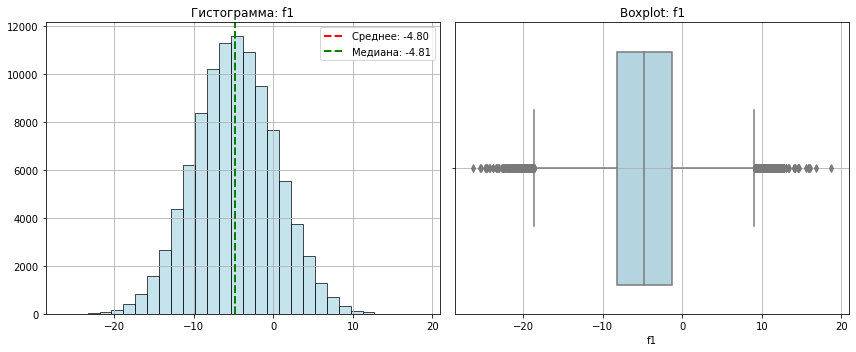

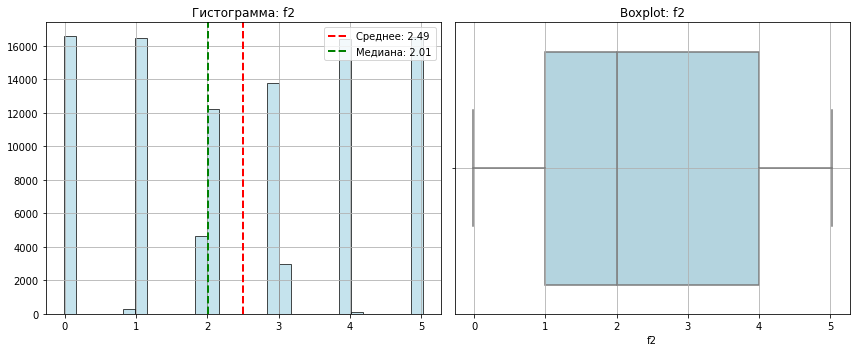

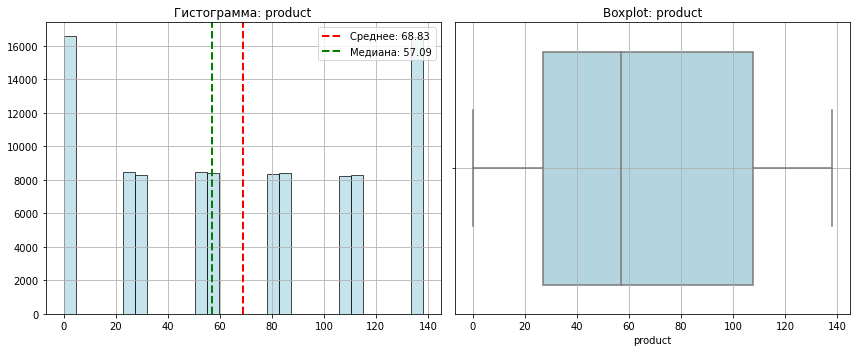

In [13]:
# построим графики для второй таблицы
col_plot(geo_data_1, geo_data_1.columns[1:])  

Распределение для f0 симметричное, с пиками около среднего значения (1.14) и медианы (1.15). Это указывает на нормальное распределение. Данные равномерно распределены внутри межквартильного диапазона.

Распределение для f1 также симметричное. Данные также распределены нормально. Некоторые выбросы присутствуют, но они не сильно влияют на распределение данных, так как они не смещают среднее.

 Для f2 наблюдается скошенность: среднее 2.49 и медиана 2.01 указывают на асимметричное распределение данных. Присутствуют очень высокие значения, влияющие на увеличение среднего арифметического.

Распределение для объема запасов нефти (product) имеет несколько пиков в разных областях , со средним значением около 68.83 и медианой 57.09. Это может свидетельствовать о том, что данные имеют несколько кластеров. Среднее сильно смещено в большую сторону, следовательно в данных присутствуют выбросы с высокими значениями. 

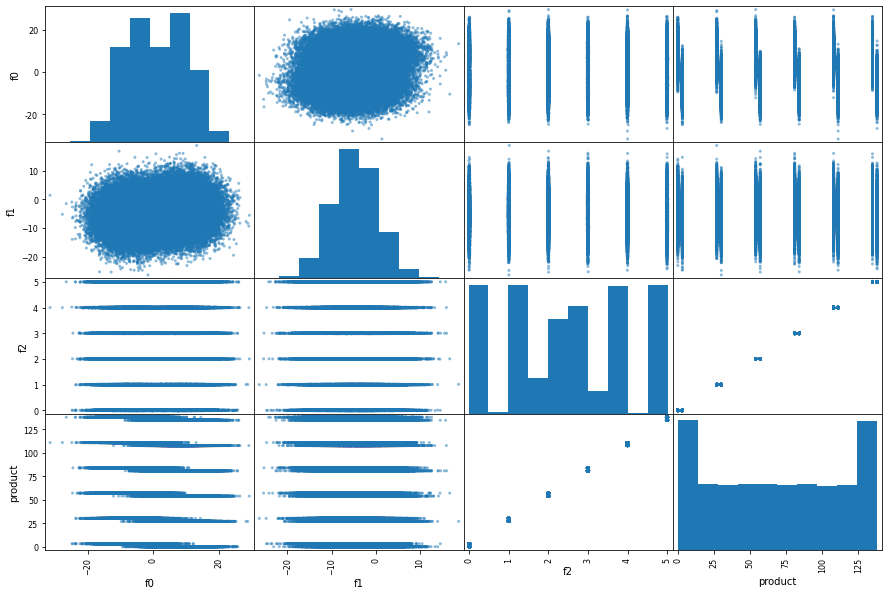

In [14]:
pd.plotting.scatter_matrix(geo_data_1, figsize=(15, 10))
plt.show()

f0 и f1: Данные распределены равномерно и не образуют четких закономерностей.

f0 и product: Много точек сосредоточено в нижней части графика, что подтверждает, что между f0 и объемом запасов нефти существует слабая зависимость.

f1 и f2: Большинство точек расположены вдоль горизонтальной оси, что может указывать на отсутствие значимых взаимосвязей.

f2 и product: Между этими признаками существует явная зависимость

<AxesSubplot:>

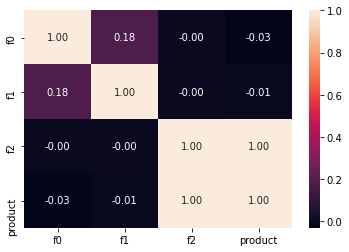

In [15]:
# построим матрицу корреляции
sns.heatmap(geo_data_1.corr(), annot=True, fmt='.2f') 

Признаки f2 и product полностью зависят друг от друга. С повышением одного из признаков непременно растет и целевой. Данные необходимо обработать, чтобы линейная модель не теряла своего качества 

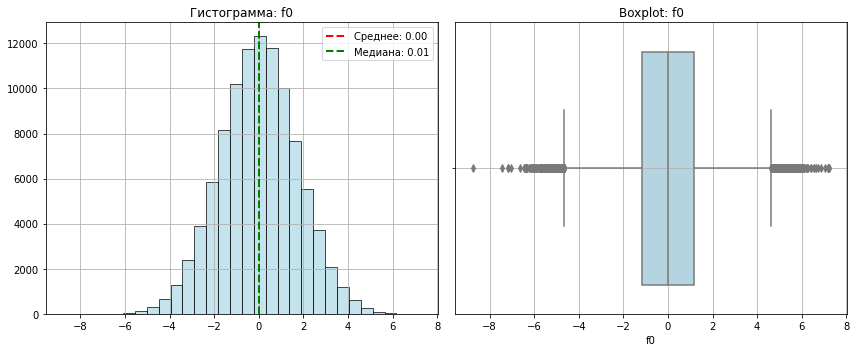

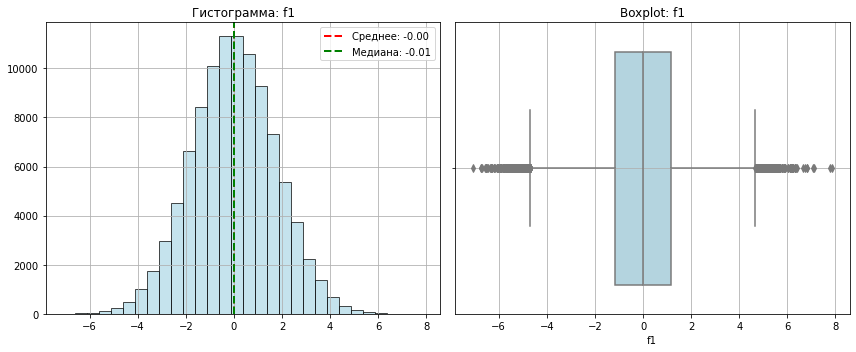

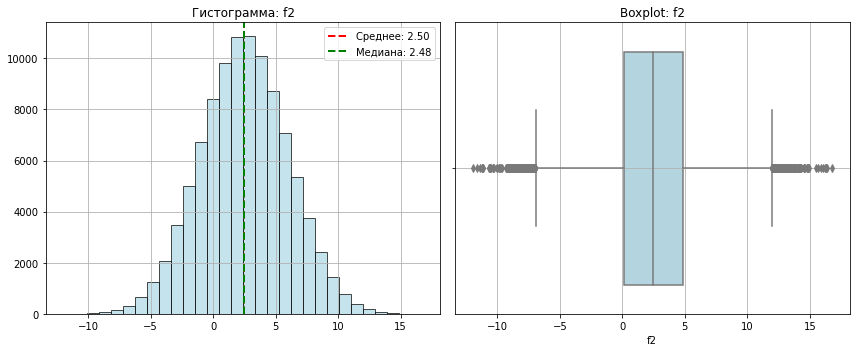

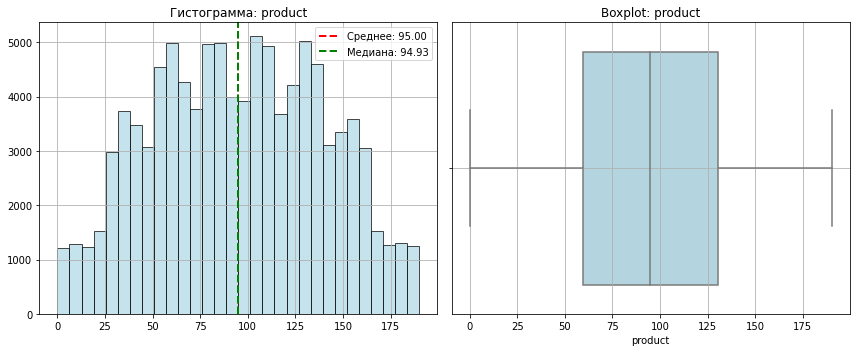

In [16]:
# построим графики для третьей таблицы
col_plot(geo_data_2, geo_data_2.columns[1:])  

Данные для f0 выглядят как симметричное распределение, с центром в 0.00 (среднее). Распределение приближено к нормальному, с преобладанием наблюдений около нуля. Видно, что значения сосредоточены в пределах межквартильного диапазона, и выбросы, если они есть, не сильно влияют на распределение.

Распределение для f1 также симметричное, с центром около 0.00 (среднее) и -0.01 (медиана). Есть выбросы, но в целом, распределение близкое к нормальному, с основным скоплением внутри межквартильного диапазона.

Для f2 видно симметричное распределение с пиковой точкой около 2.50 (среднее) и медианой 2.48.

Для объема запасов нефти распределение также симметричное, со средним равным 95. Большинство значений находятся в пределах 50-150.
Наблюдаются несколько выбросов, но в целом данные сосредоточены в пределах межквартильного диапазона.

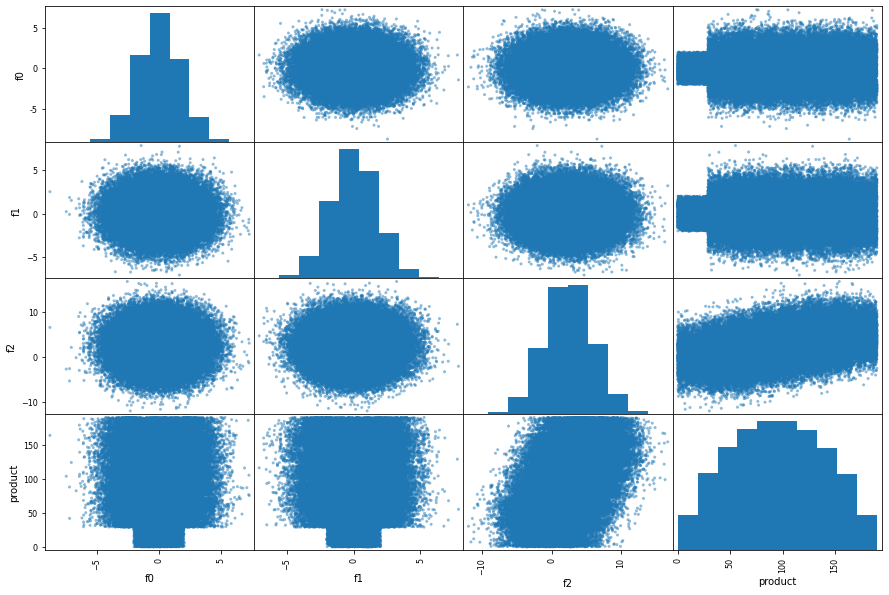

In [17]:
pd.plotting.scatter_matrix(geo_data_2, figsize=(15, 10))
plt.show()

f2 и product: Между этими признаками наблюдается линейная зависимость, что может указывать на то, что f2 имеет некоторый эффект на объем нефти.

f0, f1 и product: Между ними и объемом нефти также нет явной зависимости. Однако видно, что product сосредоточен в определенном диапазоне. 

<AxesSubplot:>

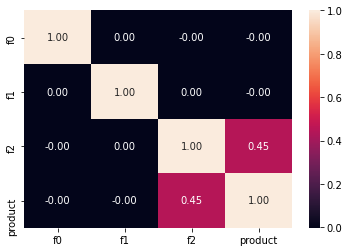

In [18]:
# построим матрицу корреляции
sns.heatmap(geo_data_2.corr(), annot=True, fmt='.2f') 

Корреляция между признаками f2 и product равняется 0.45. Несмотря на то что линейная зависимость есть, это еще не мультиколлинеарность

Выводы:
1. Предобработка данных:
Все три таблицы прошли проверку на дубликаты, пропуски и были преобразованы: столбцы приведены к нижнему регистру с заменой пробелов на подчеркивания. Пропусков и дубликатов не было обнаружено. Числовые столбцы показали нормальное распределение с небольшими выбросами.

2. Графики распределения:
    Для каждого датафрейма были построены графики распределения признаков, включая гистограммы и боксплоты. Вот основные выводы:
- Признаки f0 и f1 имеют симметричное распределение с пиками около среднего, что указывает на нормальное распределение.
- Признак f2 в большинстве датасетов имеет асимметричное распределение, что свидетельствует о смещении в сторону положительных значений.
- Признак product распределен в основном в диапазоне 50-150, с наличием выбросов.

3. Корреляция признаков:
В первом датафрейме наблюдается отрицательная корреляция между f0 и f1, а также положительная зависимость между f2 и product. Во втором датафрейме заметна мультиколлинеарность между f2 и product. В третьем датафрейме линейная зависимость между f2 и product подтверждается коэффициентом корреляции 0.45.

## Обучение и проверка модели

В данном случае ниболее подходящей моделью для предсказания является линейная регрессия. Она хорошо справляется с предсказанием конкретных значений, улавливает линейные зависисмости и достаточно хорошо интерпретируема.


Создадим функцию с помощью которой:

    - Разобьем данные на обучающую и валидационную выборки в соотношении 75:25
    - Обучим модель линейной регрессии и сделаем предсказания на валидационной выборке
    - Сохраним предсказания и правильные ответы на валидационной выборке
    - Напечатаем на экране средний запас предсказанного сырья и RMSE модели.

In [19]:
def pipeline_geo_data(df_geo):
    X = df_geo.drop(['product', 'id'], axis=1)
    y = df_geo['product']

    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size = TEST_SIZE,
                                                        random_state = RANDOM_STATE
                                                        )

    print('количество дублированных строк во входных признаках тренировочной и тестовой выборок:', X_train.duplicated().sum(), X_test.duplicated().sum())
    print('размерность выборок:', X_train.shape, X_test.shape)

    # Списки признаков
    num_columns = ['f0', 
                   'f1',
                   'f2' 
                  ]

    # Пайплайн для числовых данных с добавлением полиномиальных признаков
    num_pipe = Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2, include_bias=False)), 
        ('select', SelectKBest(score_func=f_regression, k='all'))   
    ])

    # Общий ColumnTransformer для подготовки данных
    data_preprocessor = ColumnTransformer([
        ('num', num_pipe, num_columns)
    ])

    # Создание скорера для RMSE
    def rmse_scorer(y_true, y_pred):
        return np.sqrt(mean_squared_error(y_true, y_pred))

    rmse_scorer = make_scorer(rmse_scorer, greater_is_better=False)

    # Пайплайн для линейной регрессии
    model_lr = Pipeline([
        ('preprocessor', data_preprocessor),
        ('model', LinearRegression())
    ])

    param_grid_lr = {
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
        'preprocessor__num__poly__degree': [1, 2, 3]
    }

    print("Поиск гиперпараметров для Linear Regression:")
    start = time.time()
    linear_mod_rs = RandomizedSearchCV(
        model_lr,
        param_distributions=param_grid_lr,
        cv=5,
        scoring=rmse_scorer,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        n_iter=6,
        verbose=1
    )
    linear_mod_rs.fit(X_train, y_train)
    print(f" Linear Regression обучение завершено за {round(time.time() - start, 2)} сек")
    print("Лучшая модель (Linear Regression):\n", linear_mod_rs.best_estimator_)
    print("RMSE (кросс-валидация):", -(linear_mod_rs.best_score_))

    best_model = linear_mod_rs.best_estimator_
    best_name = "Linear Regression"
    best_cv_score = linear_mod_rs.best_score_
    
    print(f"\n Лучшая модель: {best_name}")
    print(f"RMSE на кросс-валидации: {-(best_cv_score):.4f}")

    # Оценка на тестовой выборке 
    y_test_pred = best_model.predict(X_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    print(f" RMSE на тестовой выборке: {rmse_test:.4f}")
    print(f" Средний запас предсказанного сырья: {y_test_pred.mean():.2f}")
    print(f" Средний истинный запас сырья: {df_geo['product'].mean():.2f}")
    
    # Создаем сериес с предсказанными значениями, индексы которой совпадают с исходными
    predicted_series = pd.Series(y_test_pred, index=X_test.index)
    
    # Возвращаем предсказания
    return y_test_pred, y_test

In [20]:
y_test_pred_0, y_test_0 = pipeline_geo_data(geo_data_0)
average_stock_0 = round(y_test_pred_0.mean(), 2)

количество дублированных строк во входных признаках тренировочной и тестовой выборок: 0 0
размерность выборок: (75000, 3) (25000, 3)
 Поиск гиперпараметров для Linear Regression:
Fitting 5 folds for each of 6 candidates, totalling 30 fits
 Linear Regression обучение завершено за 11.78 сек
Лучшая модель (Linear Regression):
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=3,
                                                                                      inc

В данном случае, модель линейной регрессии работает нормально, так как RMSE на тестовой выборке находится в пределах разумного значения, и результаты модели стабильны. Но все-таки ее можно улучшить так как средняя квадратичная ошибка составляет 1/5 от максимального значения product. Стоит обратить внимание на то, что RMSE на кросс-валидации и на тестовой выборке практически одинаковы, что говорит о том, что модель не переобучилась и хорошо обобщает.

во второй таблице признак f2 почти полностью коррелирует с целевым признаком. Если его оставить, оценка результатов модели будет слишком оптимистичной так как модель переобучится. Но если удалить данный признак модель будет слишком часто ошибаться, так как будет обучена лишь на двух признаках. Если бы признаков было больше и они были бы более информативными - его бы следовало удалить, либо изменить

In [21]:
y_test_pred_1, y_test_1 = pipeline_geo_data(geo_data_1)
average_stock_1 = round(y_test_pred_1.mean(), 2)

количество дублированных строк во входных признаках тренировочной и тестовой выборок: 0 0
размерность выборок: (75000, 3) (25000, 3)
 Поиск гиперпараметров для Linear Regression:
Fitting 5 folds for each of 6 candidates, totalling 30 fits
 Linear Regression обучение завершено за 12.01 сек
Лучшая модель (Linear Regression):
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=3,
                                                                                      inc

В этом случае RMSE на кросс-валидации и тестовой выборке также совпадают, что свидетельствует о стабильности модели. Однако значение RMSE значительно ниже, чем в первом регионе, это связано с тем, что входной и целевой признаки коррелируют. Это привело к переобучению модели. Здесь средний запас предсказанного сырья значительно ниже, чем в первом регионе

In [22]:
# обучим модель для третьего региона
y_test_pred_2, y_test_2 = pipeline_geo_data(geo_data_2)
average_stock_2 = round(y_test_pred_2.mean(), 2)

количество дублированных строк во входных признаках тренировочной и тестовой выборок: 0 0
размерность выборок: (75000, 3) (25000, 3)
 Поиск гиперпараметров для Linear Regression:
Fitting 5 folds for each of 6 candidates, totalling 30 fits
 Linear Regression обучение завершено за 11.83 сек
Лучшая модель (Linear Regression):
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=3,
                                                                                      inc

В третьем регионе RMSE на тестовой выборке также близко к значению на кросс-валидации, что указывает на стабильность модели. Однако RMSE в этом случае снова немного выше, чем в первом регионе, что может свидетельствовать о необходимости увеличения числа информативных входных признаков для обучения модели. Средний запас предсказанного сырья (94.74) близок к значению в первом регионе, что подтверждает адекватность модели в контексте задачи.

В ходе выполнения проекта, посвящённого выбору локации для скважины, была использована линейная регрессия для предсказания объёма сырья в скважинах. Основные этапы работы включают подготовку данных, обучение модели и оценку её результатов.

Обучение и проверка модели:
1. Для каждого региона был выполнен анализ данных с разделением на обучающую и тестовую выборки в соотношении 75:25.
2. Модель линейной регрессии была обучена и протестирована с использованием кросс-валидации и метрики RMSE. Результаты модели были оценены на валидационных и тестовых данных.
3. Для первого региона средний запас предсказанного сырья составил 92.45 тыс. баррелей, что в целом хорошо согласуется с реальными данными, а значение RMSE на тестовой выборке оказалось в пределах разумного (37.33), что подтверждает адекватность модели.
4. Проблемы с переобучением во втором регионе:
- Во втором регионе наблюдается сильная корреляция между признаком f2 и целевым значением product, что привело к переобучению модели и слишком оптимистичной оценке её результатов.
- Средний запас предсказанного сырья оказался значительно ниже (68.72), что отражает слабую предсказательную способность модели из-за сильной корреляции.
5. Третий регион и стабильность модели:
- В третьем регионе результат RMSE оказался близким к результатам первого региона, что указывает на стабильность модели.
- Несмотря на это, значение RMSE несколько выше, что может свидетельствовать о необходимости увеличения числа информативных признаков для улучшения предсказаний.

## Подготовка к расчёту прибыли

создадим переменные, необходимые для расчета прибыли

In [23]:
# создадим переменную budget (бюджет на разработку скважин в регионе)
budget = 10000000000

# создадим переменную revenue_per_1_barrel (доход с одного барреля)
revenue_per_1_barrel = 450

# создадим переменную revenue_per_1000_barrel (доход с тысячи баррелей)
revenue_per_1000_barrel = revenue_per_1_barrel * 1000

# вероятность убытков
probability = 2.5

# количество скважин для разработки
num_wells_main = 500

# количество лучших скважин для разработки
num_wells = 200

# посчитаем стоимость разработки одной скважины
well_cost = budget / num_wells
print(f"Стоимость разработки одной скважины: {well_cost}")

# рассчитаем точку безубыточности и создадим переменную, для этого разделим стоимость разработки одной скважины на выручку с тысячи баррелей
min_product = round((well_cost / revenue_per_1000_barrel), 2)

print(f" Средний запас сырья\n в первом регионе: {round(geo_data_0['product'].mean(), 2)},\n во втором регионе {round(geo_data_1['product'].mean(), 2)},\n в третьем регионе {round(geo_data_2['product'].mean(), 2)}\n\n достаточный объём сырья для безубыточной разработки новой скважины {min_product}")

Стоимость разработки одной скважины: 50000000.0
 Средний запас сырья
 в первом регионе: 92.5,
 во втором регионе 68.83,
 в третьем регионе 95.0

 достаточный объём сырья для безубыточной разработки новой скважины 111.11


Судя по данным, средний объем запасов нефти в каждом из регионов меньше точки безубыточности. То есть вложения не окупятся, так как объема запасов в скважинах не достаточно, чтобы покрыть затраты.

## Расчёт прибыли и рисков 

Создадим функцию для подсчета прибыли с двухсот скважин с наиболее высокими значениями предсказаний объема сырья по каждому региону.

In [24]:
def profit(predictions, target):

    '''
        Функция принимает на вход набор предсказаний и целевой
        признак тестовой выборки каждого региона
        и производит расчет прибыли от скважины
    '''
    # Отсортируем предсказанные данные по убыванию
    probs_sorted = pd.Series(predictions).sort_values(ascending=False)

    # Выберем 200 точек с самым высоким значением запасов нефти
    top_target = target[probs_sorted.index][:num_wells]

    # Вычислим значение прибыли по этим точкам
    revenue = top_target.sum() * revenue_per_1000_barrel

    return revenue - budget

Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.

Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков.

In [25]:
def bootstrap_profit(predictions, target):

    '''
        Функция применяет технику Bootstrap с 1000 выборок
        предсказанных значений по каждому региону
    '''

    values = [] # сюда будем собирать прибыль по каждой итерации

    # Цикл перебора для выборок Bootstrap
    for i in range(1000):
        predictions_sample = pd.Series(predictions).sample(n=num_wells_main, replace=True, random_state=state) 
        values.append(profit(predictions_sample, target.reset_index(drop=True)))

    # Запишем значение распределения выборок в объект Series
    values = pd.Series(values)

    # Определим целевые показатели
    lower = values.quantile(.025)
    upper = values.quantile(.975)
    mean_revenue = sum(values) / len(values)
    risk_loss = len(values[values<=0]) / len(values)
    
    return mean_revenue, lower, upper, risk_loss, values

In [26]:
# выведем результаты
average_0, lower_0, upper_0, risk_0, values_0 = bootstrap_profit(y_test_pred_0, y_test_0)
print("регион 1")
print(f" Средняя прибыль: {average_0:.2f}")
print(f" 95%-й доверительный интервал:  {lower_0:.2f} - {upper_0:.2f}")
print(f" Риск (вероятность убытка): {risk_0:.2%}\n\n")



average_1, lower_1, upper_1, risk_1, values_1 = bootstrap_profit(y_test_pred_1, y_test_1)
print("регион 2")
print(f" Средняя прибыль: {average_1:.2f}")
print(f" 95%-й доверительный интервал:  {lower_1:.2f} - {upper_1:.2f}")
print(f" Риск (вероятность убытка): {risk_1:.2%}\n\n")



average_2, lower_2, upper_2, risk_2, values_2 = bootstrap_profit(y_test_pred_2, y_test_2)
print("регион 3")
print(f" Средняя прибыль: {average_2:.2f}")
print(f" 95%-й доверительный интервал: {lower_2:.2f} - {upper_2:.2f}")
print(f" Риск (вероятность убытка): {risk_0:.2%}")

регион 1
 Средняя прибыль: 456641081.76
 95%-й доверительный интервал:  -70890109.52 - 972175545.31
 Риск (вероятность убытка): 4.90%


регион 2
 Средняя прибыль: 441515722.36
 95%-й доверительный интервал:  35728489.28 - 828006639.00
 Риск (вероятность убытка): 1.60%


регион 3
 Средняя прибыль: 573888363.47
 95%-й доверительный интервал: 32884243.82 - 1073883502.56
 Риск (вероятность убытка): 4.90%


1. Средняя прибыль:


- Регион 1: Средняя прибыль = 456,64 млн руб.
- Регион 2: Средняя прибыль = 441,52 млн руб.
- Регион 3: Средняя прибыль = 573,89 млн руб.


Регион 3 имеет наибольшую среднюю прибыль (573,89 млн руб.), что делает его наиболее прибыльным, несмотря на его более высокий риск.


2. 95%-й доверительный интервал:

- Регион 1: от -70.89 млн руб. до 972.18 млн руб.
- Регион 2: от 35.73 млн руб. до 828.01 млн руб.
- Регион 3: от 32.88 млн руб. до 1,07 млрд руб.


Все регионы имеют довольно широкий доверительный интервал прибыли, что указывает на высокую степень неопределенности в прогнозах. Особенно это заметно в регионе 1, где доверительный интервал охватывает как отрицательные, так и высокие значения прибыли.



3. Риск убытков (вероятность убытка):


- Регион 1: 4.90% — высокий риск.
- Регион 2: 1.60% — низкий риск.
- Регион 3: 4.90% — высокий риск.

Регион 2 имеет самый низкий риск убытков (1.6%), что делает его наименее рискованным для разработки. Это может быть связано с переобучением при построении модели из-за которого средняя квадратичная ошибка была минимальной. Регионы 1 и 3 имеют более высокий риск убытков (по 4.9%).

Если основной критерий для выбора региона — это минимизация риска, тогда следует выбрать регион 2, так как его риск убытков наименьший.


Если предпочтительнее максимизация средней прибыли, то регион 3 будет наиболее привлекательным, несмотря на более высокий риск.


Таким образом под условие задачи (нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%.) попадает только второй регион

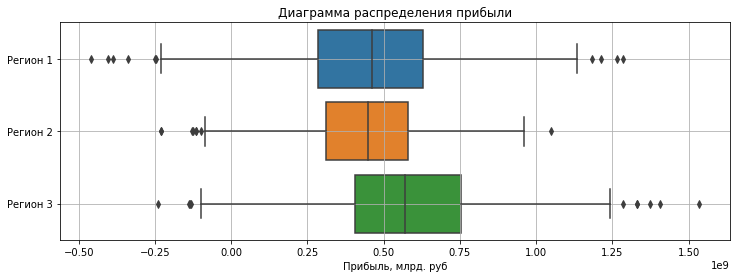

In [27]:
# cоздадим датафрейм со значениями прибыли после bootstrap
values_result = pd.DataFrame({'Регион 1': values_0,
                              'Регион 2': values_1,
                              'Регион 3': values_2})

# построим боксплот, чтобы визуализировать распределение прибыли 
plt.figure(figsize=(12, 4))
sns.boxplot(data=values_result, orient='h')
plt.title('Диаграмма распределения прибыли')
plt.xlabel('Прибыль, млрд. руб')
plt.grid()
plt.show()

Проанализировав диаграмму распределения прибыли для трёх регионов, можно сделать следующие выводы:

1. Регион 1:
- Значение прибыли для региона 1 сильно варьируется, включая негативные значения (убытки), о чём свидетельствуют довольно длинные усы на графике.
- Основная масса прибыли сосредоточена в пределах 0.0 и 0.5 млрд руб, но возможны выбросы (как большие значения прибыли, так и большие убытки), что указывает на высокий риск.


2. Регион 2:
- В регионе 2 риск убытков значительно ниже. разброс в целом сосредоточен вокруг средней прибыли, с минимальными убытками и относительно узким диапазоном. прибыль находится в пределах от 0.0 до 0.75 млрд руб.


3. Регион 3:
распределение похоже на регион 1. Показания сосредоточены в пределах от 0.0 до 1.25 млрд руб. и есть серьёзные выбросы, что говорит о высоком потенциале как прибыли, так и убытков.

## Вывод по проекту


В рамках проекта был проведён анализ и выбор оптимального региона для бурения новых скважин для компании «ГлавРосГосНефть». Задача заключалась в том, чтобы с использованием машинного обучения и анализа рисков определить, в каком регионе добыча нефти принесёт наибольшую прибыль.


Что было сделано:


1. Подготовка данных:
- Все три региона были исследованы с помощью графиков распределения признаков, выявлены зависимости между признаками и целевым значением (объём нефти в скважине).
- Для второго региона была обнаружена сильная корреляция между признаком f2 и целевым значением, что могло привести к переобучению модели.


2. Обучение модели:
- Модель линейной регрессии была обучена для каждого региона.
- Прогнозы на тестовых выборках для всех регионов дали адекватные результаты с показателями RMSE в пределах разумных значений (для первого региона: 37.33, для второго: 0.78 и для третьего: 38.83).
- Модель во втором регионе показала низкое значение RMSE, но это связано с сильной корреляцией между признаками.


3. Анализ прибыли:
- Для каждого региона был рассчитан минимальный объём нефти, необходимый для безубыточной разработки скважин, и проведён расчёт прибыли по 200 лучшим скважинам.


- Прогнозы по прибыли для каждого региона показали, что:
    - Регион 1: Средняя прибыль — 456.64 млн руб. с риском убытков 4.9%.
    - Регион 2: Средняя прибыль — 441.52 млн руб. с риском убытков 1.6%.
    - Регион 3: Средняя прибыль — 573.89 млн руб. с риском убытков 4.9%.
    
    
4. Оценка рисков методом Bootstrap:
- Регион 2 оказался наиболее стабильным с самым низким риском (1.6%).
- Регион 3 показал наибольшую среднюю прибыль, но его риск был выше, чем у региона 2.
- Регион 1 показал схожие результаты с регионом 3, но с немного меньшей прибылью.


5. Выбор региона:
- Несмотря на более высокую прибыль региона 3, его высокий риск делает его менее предпочтительным по условиям задачи.

- Для минимизации рисков и максимизации прибыли рекомендуется выбрать регион 2. низкий риск и стабильная прибыль делают его оптимальным для бурения новых скважин, соответствующим требованиям задачи.